Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


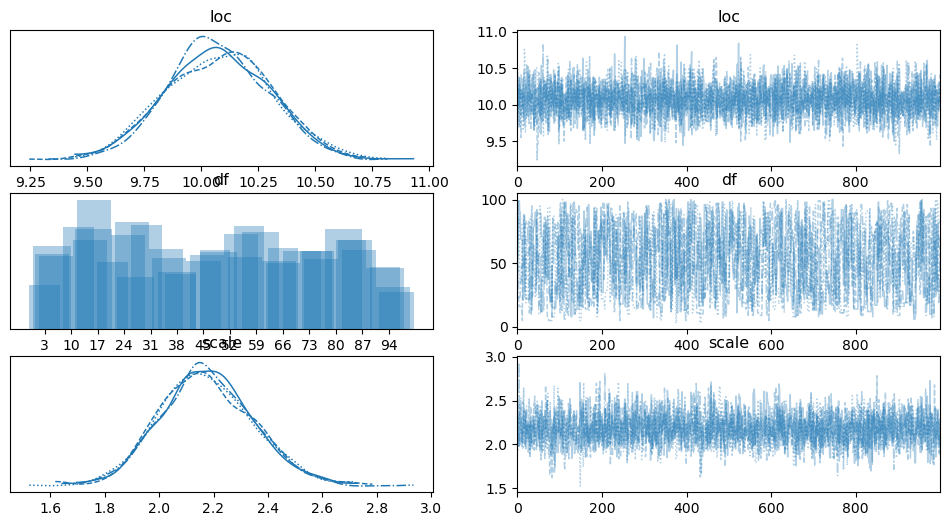

         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
loc    10.075   0.227   9.654   10.494      0.004    0.003    3814.0   
df     52.017  27.686   9.000   96.000      1.068    0.755     676.0   
scale   2.175   0.173   1.874    2.514      0.004    0.003    2061.0   

       ess_tail  r_hat  
loc      2779.0    1.0  
df        677.0    1.0  
scale    2018.0    1.0  


In [3]:
from scipy import stats; import pymc as pm; import numpy as np; import arviz as az; import matplotlib.pyplot as plt

n,loc_true,scale_true,df_true = 100,10,2,15
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

model = pm.Model()

mu_0,sigma_0=0,10
T=1000

with model:
    loc = pm.Normal('loc', mu_0, sigma_0)
    scale = pm.HalfNormal('scale', sigma=5)
    df = pm.DiscreteUniform('df', lower=1, upper=100)
    x_obs = pm.StudentT('likelihood', nu=df, mu=loc, sigma=scale, observed=x)
    trace = pm.sample(T)

with model:
    az.plot_trace(trace)
    plt.show()

    summary = az.summary(trace)
    print(summary)

Try different T to explore sample sizes

Part 2

Eight Schools

In [12]:
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
     
with pm.Model() as Centered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
 
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) 
    
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
SEED = [20100420, 20134234,20134238, 201342349]
with Centered_eight:
    fit_C = pm.sample(5000, chains=4, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 606 divergences after tuning. Increase `target_accept` or reparameterize.


In [6]:
with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)


    theta = pm.Deterministic("theta", mu + tau * theta_tilde)

    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

In [10]:
with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=4, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

ValueError: Number of seeds (2) does not match the number of chains (4).

In [ ]:
import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])

In [9]:
fit_C.sample_stats.acceptance_rate.values.flatten() 
fit_NC.sample_stats.acceptance_rate.values.flatten()

array([0.96584575, 0.96401304, 0.95955225, ..., 0.91078674, 0.86984342,
       0.94029322])

report: 
Uncentered one has fewer divergences then centered.

AI: I used chatgpt for debugging and coding part 1